# A simple poisson solver using isogeometry

This note will describe my implementation of a simple poisson solver using B-splines as basis functions.

## Poisson's equation
Our main goal is to build a simple FEM solver for the Poisson problem i 2D using B-splines. The problem reads
\begin{equation}
    \begin{split}
        -\Delta u &= f \quad \mbox{ on } \Omega \\
        u&=g \quad \mbox{ on } \partial\Omega,
    \end{split}
\end{equation}
where $g$ is a function taking some value at the boundary.
### Weak formulation
Multiplying the above problem with a test function $v\in V$, where $V=\{w:w\in H^1(\Omega), w|_{\Gamma_D}=0\}$, integrating by parts and using that $v|_{\Gamma_D}=0$  we obtain the weak formulation. The problem is now to find $u\in U$ s.t. for all $v\in V$
\begin{equation}
    \iint_\Omega\nabla u \cdot \nabla v \mbox{dxdy} = \iint_\Omega fv \mbox{dxdy}, 
\end{equation}
where $U=\{u:u\in H^1(\Omega), u|_{\Gamma_D}=g\}$
We can rewrite the weak form as 
\begin{equation}
    a(u,v)=F(v).
\end{equation}
Notice that $a(\cdot,\cdot)$ is bilinear and symmetric and $F(\cdot)$ is linear. 

To solve this problem approximately we turn to Galerkin's method to approximate the infinite dimensional spaces $U$ and $V$ by some finite dimensional spaces $U^h$ and $V^h$. The problem is now reduced to finding $u^h\in U^h$ s.t. for all $v^h\in V^h$ the above equation is solved. For a given function $u_g^h$ s.t. $u_g|_{\Gamma_D}=g$, there exist a function $u_0^h\in V^h$ s.t. $u^h=u_0^h+u_g^h\in U$. For now we will only consider the homogeneous dirichlet boundary conditions, i.e. $u|_{\Gamma_D}=0$ and in fact the weak formulation will be reduced to finding a $u^h\in V^h$. For simplicity I will hereby use the notation $u$ for $u^h$, $v$ for $v^h$. 

### B-spline basis functions and its first derivatives
The B-spline functions are defined recursively based on the Cox - de Boor recursion formula (Isogeometric Analysis, p. 20) starting with piecewise constants for $p=0$
\begin{equation}
    N_{i,0}(\xi)=
    \begin{cases} 
      1 & \mbox{if } \xi_i \leq \xi < \xi_{i+1}  \\
      0 & \mbox{otherwise}
          \end{cases}
\end{equation}

For $p=1, 2, 3,\dots $
\begin{equation}
N_{i,p}(\xi)=\frac{\xi-\xi_i}{\xi_{i+p}-\xi_i}N_{i,p-1}(\xi)+\frac{\xi_{i+p+1}-\xi}{\xi_{i+p+1}-\xi_{i+1}}N_{i+1,p-1}(\xi)
%\label{CoxdeBoor}
\end{equation}
In the case of repeated knots, i.e. when the multiplicity $m_i$ of a knot $\xi_i$ is greater than one the nominator in the equation above may be zero and hence we define 
\begin{equation}
\frac{0}{0}\overset{.}{=}0
\end{equation}

In 2D we have $n$ basis functions in the $\xi$-direction and $m$ basis functions in the $\eta$-direction, resulting in the basis functions $\tilde{N}_A(\xi,\eta)=N_i(\xi)N_j(\eta)$ for $A=1,\dots,nm$

The derivatives is given by equation (2.12) p. 28 in Isogeometric Analysis
\begin{equation}
\frac{d}{d\xi}N_{i,p}=\frac{p}{\xi_{i+p}}N_{i,p-1}(\xi)-\frac{p}{\xi_{i+p+1}-\xi_{i+1}}N_{i+1,p-1}(\xi)
\end{equation}
As we see from the weak formulation what's interesting is the gradient of the basis functions $\tilde{N}_A$
\begin{equation}
    \tilde{N}_A=\left[ {\begin{array}{c}
          \frac{\partial \tilde{N}_A(\xi,\eta)}{\partial \xi}\\
          \frac{\partial \tilde{N}_A(\xi,\eta)}{\partial \eta}\\
  \end{array} } \right]
  = \left[ {\begin{array}{c}
          \frac{\partial N_i(\xi)}{\partial \xi}N_j(\eta)\\
          N_i(\xi)\frac{\partial N_j(\eta)}{\partial \eta}\\
  \end{array} } \right].
\end{equation}
### Compact support

Given open knotvectors $\Xi=\{\xi_1,\xi_2,\dots,\xi_{n+p+1}\}$ and $H=\{\eta_1,\eta_2,\dots,\eta_{m+q+1}\}$ where $n,m$ is the number of B-spline functions in $\xi-$ and $\eta-$direction respectively and $p,q$ are the corresponding degree of the basis functions. That a knotvector is open means that its first and last element is has multiplicity $p+1$, where $p$ is the polynomial degree of the basis functions. The number of elements in the parameter space is the number of distinct knots minus one, lets say $N-1$ for $\Xi$ and $M-1$ for $H$ multiplied with each other, i.e. $(N-1)\times(M-1)$ number of elements. Each element will have non-zero contributions from p+1 basis functions in the $\xi-$direction and non-zero contributions from q+1 basis functions in the $\eta-$direction. For a element $[\xi_i,\xi_{i+1}]\times[\eta_j,\eta_{j+1}]$ the basis functions $N_{i-p,p}-N_{i,p}$ is supported in the $\xi-$direction and the basis functions $M_{j-q,q}-M_{j,q}$ is supported in the $\eta-$direction.

### Mapping from physical space to parameter space
The mapping from the physical space to the parameter space is given by 
\begin{equation}
    \begin{split}
        x=\sum_{i=1}^n\sum_{j=1}^m N_{i,p}(\xi)M_{j,q}(\eta)x_{ij}, &\quad y=\sum_{i=1}^n\sum_{j=1}^m N_{i,p}(\xi)M_{j,q}(\eta)y_{ij}\\
        x=\sum_{A=1}^{nm}\tilde{N}_A(\xi,\eta)x_{A}=\mathbf{\tilde{N}^\top}\mathbf{x}, &\quad y=\sum_{A=1}^{nm}\tilde{N}_A(\xi,\eta)y_{A}=\mathbf{\tilde{N}^\top}\mathbf{y}\\
    \end{split}
\end{equation}
where $\mathbf{x},\mathbf{y}$ is the vectors containing the control points of $x$ and $y$ respectively. See $\textit{Isogeometric Analysis, }2009$ for a further explanation of the control points. Now to solve the integral above we must map it from the physical space $\tilde\Omega$  to the parameter space $\Omega$
\begin{equation}
    K_{AB}=\iint_{\tilde\Omega}\nabla\tilde{N_A}\nabla\tilde{N_B}\mbox{dxdy}=\iint_{\Omega}\nabla\tilde{N_A}(\xi,\eta)\nabla\tilde{N_B}(\xi,\eta)|J|\mbox{ d}\xi\mbox{d}\eta 
\end{equation}

where $J$ is the Jacobian
\begin{equation}
  J=
  \left[ {\begin{array}{cc}
  \frac{\partial x}{\partial \xi} & \frac{\partial x}{\partial \eta}\\
  \frac{\partial y}{\partial \xi} & \frac{\partial y}{\partial \eta}\\
  \end{array} } \right]
\end{equation}

And we do the same for the right hand side
\begin{equation}
F_B=\iint_{\tilde{\Omega}} f(x,y) \tilde{N_B} \mbox{dxdy}=\iint_{\Omega}f(x(\xi,\eta),y(\xi,\eta))\tilde{N_B}(\xi,\eta)|J|\mbox{ d}\xi\mbox{d}\eta.
\end{equation}
### Representation using B-spline basis functions
In 2D we can represent $u$ using B-spline basis functions, one for each spatial direction $N_{i,p}(\xi), M_{j,q}(\eta)$ s.t. $u = \sum_{i=1}^n\sum_{j=1}^m N_{i,p}(\xi)M_{j,q}(\eta)u_{ij}$ where $u_{ij}$ is the control points of u.Rewriting this to $u = \sum_{A=1}^{nm}\tilde{N_{A}}(\xi,\eta)u_A$ and doing a similar representation for $v$ we get from the weak formulation 
\begin{equation}
    \begin{split}
        \sum_{A=1}^{nm}\iint_\Omega\nabla\tilde{N_A}\nabla\tilde{N_B}\mbox{dxdy}u_A&=\iint_\Omega f \tilde{N_B} \mbox{dxdy}\\
        \sum_{A=1}^{nm} K_{AB}u_A&=F_B \\
        \mathbf{K}\mathbf{u}&=\mathbf{F}
    \end{split}
\end{equation}
where
\begin{equation}
    \mathbf{u}=[u_{1,1}, u_{1,2}, \dots u_{1,m},u_{2,1}, u_{2,2} ,\dots, u_{nm}]^\top
\end{equation}

\begin{equation}
  K=
  \left[ {\begin{array}{ccccccc}
   K_{(1,1)(1,1)} & K_{(1,2)(1,1)} & \dots & K_{(1,m)(1,1)} & K_{(2,1)(1,1)} & \dots & K_{(n,m)(1,1)}\\
  K_{(1,1)(1,2)} & K_{(1,2)(1,2)} & \dots & \dots & \dots & \dots & K_{(n,m)(1,2)}\\
  \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
  K_{(1,1)(1,m)} & K_{(1,2)(1,m)} & \dots & \dots & \dots & \dots & K_{(n,m)(1,m)}\\
  K_{(1,1)(2,1)} & K_{(1,2)(2,1)} & \dots & \dots & \dots & \dots & K_{(n,m)(2,1)}\\
  \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
  K_{(1,1)(n,m)} & K_{(1,2)(n,m)} & \dots & \dots & \dots & \dots & K_{(n,m)(n,m)}\\
  \end{array} } \right]
\end{equation}
and $K_{(i,j)(r,s)}=\iint_\Omega\nabla(N_i(\xi)M_j(\eta))\nabla(N_r(\xi)M_s(\eta))=\iint_\Omega(\nabla N_i(\xi)M_j(\eta)+N_i(\xi)\nabla M_j(\eta))(\nabla N_r(\xi)M_s(\eta)+N_r(\xi)\nabla M_s(\eta))$ or in a simpler notation
$K_{AB}=\iint_\Omega\nabla\tilde{N}_A(\xi,\eta)\nabla\tilde{N}_B(\xi,\eta)$

### Tools
To implement this we need some tools. We need a function to compute the basis functions and its derivative. We also need a function performing the integration, using gaussian quadrature to integrate, see section $\textit{Gaussian quadrature}$, and assembling the matrix $K$. 

#### Bspline_basis()
Takes as input x-parameter, p- is the order of the basis, i- is the i'th basis, knotvec - is the vector containing the knots. In one dimension the knot vector is a non-decreasing set of coordinates in the parameter space, $\Xi=\{\xi_1, \xi_2, \dots, \xi_{n+p+1}\}$, where $n$ is the number of basis functions used to construct the B-spline curve and $p$ is the polynomial order.
This function returns B-spline basis $N_{i,p}$ evaluated in the point $x$. 

In [3]:
import sys
sys.path.append("../../../../splipy")
#C:\Users\Lars Snekkerhaugen\splipy
import numpy as np
import matplotlib.pyplot as plt
import splipy as sp

def Bspline_basis(x, p, i, knotvec):
	# x-parameter, p- is the order of the basis, i- is the i'th basis, i.e. i>=1, knotvec - is the vector containing the knots
	if p>0:
		#Calculate first term of Cox-de Boor recursion formula
		first_term=0
		#Calculate N_{i,p-1}
		N_i=Bspline_basis(x, p-1, i, knotvec)
		#Numerator
		num1=knotvec[i+p-1]-knotvec[i-1] #-1 because of indexing
		if num1==0 and N_i == 0:
			first_term=0
		else:
			first_term=(x-knotvec[i-1])/num1*N_i #-1 because of indexing
		#Calculate second term
		second_term = 0
		#Calculate N_{i+1,p-1}
		N_i1=Bspline_basis(x,p-1,i+1,knotvec)
		num2=knotvec[i+p+1-1]-knotvec[i+1-1] #-1 because of indexing
		if num2 == 0 and N_i1 ==0:
				second_term = 0
		else:
			second_term=(knotvec[i+p+1-1]-x)/num2*N_i1 #-1 because of indexing
		N=first_term+second_term
	elif p==0:
		if x >= knotvec[i-1] and x < knotvec[i+1-1]: #-1 because of indexing
			N=1
		else:
			N=0
	else:
		print ("The order of the basis function must be >=0")
	return N

#### all_Bspline_basis
Takes as input x - vector of evaluationpoints, p - is the order of the basis, n - is the number of basis functions, knotvec - is the vector containing the knots.
Returns all the B-spline basis functions evaluated at all evaluationpoints x.

In [4]:
def all_Bspline_basis(x, p, n, knotvec):
	# x - vector of evaluationpoints, p - is the order of the basis, n - is the number of basis functions, knotvec - is the vector containing the knots
	l=len(x)
	B=np.zeros((n,l))
	for i in range(0,n):
		for j in range(0,l):
			B[i][j]=Bspline_basis(x[j],p,i+1,knotvec) #+1 because first basisfunction is N_1 
	return B

#### Plot
Ploting all B-spline basis functions for a given knotvector, p - polynomial degree, n - number of basis functions and evaluationpoints x

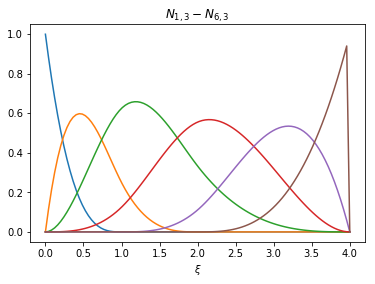

In [5]:
x=np.linspace(0,4,100)
p=3
n=6
l=len(x)
knotvec=np.array([0,0,0,0,1,2,4,4,4,4])
B=all_Bspline_basis(x,p,n,knotvec)
B=B[:,0:l]
x=x[0:l]
plt.plot(x,B.transpose())
#plt.savefig('N1,'+str(p)+'-N'+str(n)+','+str(p)+'.png')
plt.xlabel(r'$\xi$')
plt.title(r'$N_{1,'+str(p)+'}-N_{'+str(n)+','+str(p)+'}$')
plt.show()

#### all_Bspline_basis_first_derivative()


The code is based on equation (2.12) p. 28 in Isogeometric Analysis, the equation is given above.
In the code a term is defined as zero when the corresponding nominator gets zero. For a open knotvector this means that $\xi_{i+p+1}-\xi_{i+1}$ for $i=n$, hence this term is not evaluated in the code.
Assumptions: the knot vector is open, meaning we get $p+1$ repeated knots at the start and at the end of the knotvector.

In [6]:
def all_Bspline_basis_first_derivative(x, p, n, knotvec):
	B=all_Bspline_basis(x, p-1, n, knotvec)
	l=len(x)
	dB=np.zeros((n,l))
	for i in range(0,n-1):
		num1=knotvec[i+p]-knotvec[i]
		if num1==0:
			first_term=0
		else:
			first_term=(p/num1)*B[i][:]
		num2=knotvec[i+p+1]-knotvec[i+1]
		if num2==0:
			second_term=0
		else:
			second_term=(p/num2)*B[i+1][:]
		dB[i][:]=first_term-second_term
	num1=knotvec[n-1+p]-knotvec[n-1]
	if num1>0:
		dB[n-1][:]=p*B[n-1][:]/num1
	return dB

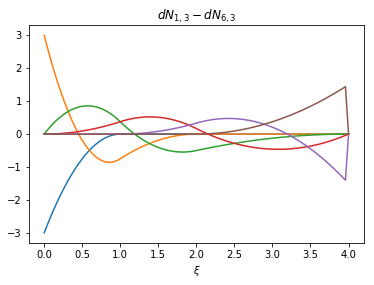

In [7]:
dB=all_Bspline_basis_first_derivative(x,p,n,knotvec)
plt.plot(x,dB.transpose())
plt.xlabel(r'$\xi$')
plt.title(r'$dN_{1,'+str(p)+'}-dN_{'+str(n)+','+str(p)+'}$')
plt.show()


#### Bspline_basis_first_derivative()
Made to be used in FEMpoisson. Compare to all_Bspline_basis_first_derivative to confirm if it works


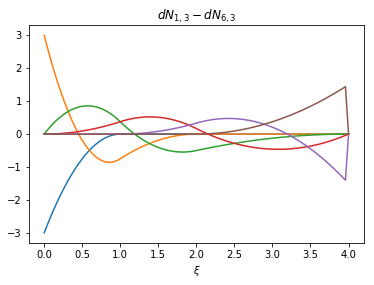

In [8]:
def Bspline_basis_first_derivative(x, p, i, knotvec):
    # x-parameter, p- is the order of the basis, i- is the i'th basis, i.e. i>=1, knotvec - is the vector containing the knots
	Bi=Bspline_basis(x, p-1, i, knotvec)
	if i < len(knotvec)-p-1: #len(knotvec)-p-1=n
		Bi1=Bspline_basis(x, p-1, i+1, knotvec)
	else:
		Bi1=0
	num1=knotvec[i+p-1]-knotvec[i-1] #-1 because of indexing
	if num1==0:
		first_term=0
	else:
		first_term=(p/num1)*Bi
	num2=knotvec[i+p+1-1]-knotvec[i+1-1] #-1 because of indexing
	if num2==0:
		second_term=0
	else:
		second_term=(p/num2)*Bi1
	dB=first_term-second_term
	return dB

l=len(x)
dB=np.zeros((n,l))
for i in range(0,n):
    for j in range(0,l):
        dB[i,j]=Bspline_basis_first_derivative(x[j], p, i+1, knotvec) #+1 because first basisfunction is N_1 
            
plt.plot(x,dB.transpose())
plt.xlabel(r'$\xi$')
plt.title(r'$dN_{1,'+str(p)+'}-dN_{'+str(n)+','+str(p)+'}$')
plt.show()

#### computeBasis()
Uses $Bspline\_basis()$ and $Bspline\_basis\_first\_derivative()$ to compute all 2D basis functions $\tilde{N}_A(\xi,\eta)$ consisting of the basis functions $N_i(\xi)$ in the $\xi$-direction and $N_j(\eta)$ in the $\eta$-direction, where $i$ is given by the elements in $N\_x\_number$ and $j$ is given by the elements in $N\_y\_number$. $\tilde{N}_A(\xi,\eta)$ is evaluated at the point $(\xi,\eta)$, given as an input to the function. The same is done for the gradients $\nabla \tilde{N}_A(\xi,\eta)$. The basis functions are returned as an array, the gradients are returned as a matrix with two rows, one for each element and the global indices of the functions are returned as an array.


In [9]:
def computeBasis(xi, eta, knot_x, knot_y,N_x_number,N_y_number,p,q,n,m):
    # This function will compute the basis functions Ñ(\xi,\eta)_A=N_i(\xi) M_j(\eta) and its derivatives
    # for basis functions given in the vectors N_x_number and N_y_number
    # which have compact support on element [el_x]x[el_y]
    # Make these basis functions and its derivatives
    # n,m gives the total number of basis functions in x-direction and y-direction
    # respectively. Needed to return the correct global index vector I
    # Returns N, dN, I.astype(int)
    lx=len(N_x_number)
    ly=len(N_y_number)
    Nx=np.zeros(lx)
    dNx=np.zeros(lx)
    ind=0
    for r in N_x_number:
        Nx[ind]=Bspline_basis(xi,p,r,knot_x)
        dNx[ind]=Bspline_basis_first_derivative(xi, p, r, knot_x)
        ind+=1
    Ny=np.zeros(ly)
    dNy=np.zeros(ly)
    ind=0
    for r in N_y_number:
        Ny[ind]=Bspline_basis(eta,q,r,knot_y)
        dNy[ind]=Bspline_basis_first_derivative(eta, q, r, knot_y)
        ind+=1
    N=np.zeros(lx*ly)
    # Each gradient will be a vector
    dN=np.zeros((2,lx*ly))
    I=np.zeros(lx*ly) # Index vector keeping track of global index
    for r in range(0,lx):
        for s in range(0,ly):
            N[s+r*ly]=Nx[r]*Ny[s]
            dN[0,s+r*ly]=dNx[r]*Ny[s]
            dN[1,s+r*ly]=Nx[r]*dNy[s]
            I[s+r*ly]=(N_x_number[r]-1)*m+N_y_number[s]
    return N, dN, I.astype(int)


#### Gaussian quadrature

For the integration we use a Gaussian quadrature rule in 2D over a square as the parameter space will be divided into rectangles. Then the integration over the square $\tilde\Omega=[-1,-1]\times[1,1]$ is easily mapped to integrate over the rectangle $\Omega=[a,c]\times[b,d]$. For the Gaussian quadrature rule in 1D we have 
\begin{equation}
\int_{-1}^{-1}g(x)dx\approx\sum_{q=1}^{Nq}\rho_qg(z_q),
\end{equation}
where $N_q$ is the number of quadrature points, $\rho_q$ Gaussian quadrature weights associated with the Gaussian quadrature points $z_q$. For the 2-point rule in 1D $z_q=\{-\frac{1}{\sqrt{3}},\frac{1}{\sqrt{3}}\}$ and $\rho_q=\{1,1\}$ and expanding this to a 4-point rule in 2D we see the quadrature scheme in the following figure

![Gaussian 4-point quadrature rule in 2D](4pointrule.png)

with the weights $\rho_p=\{1,1\}$ in the $x$-direction and $\rho_q=\{1,1\}$ in the $y$-direction. The outer product between the weight-vectors will give the weights for each quadrature point,  meaning 1 for each of the quadrature points given by the combination of the quadrature points in $x$- and $y$-direction $z_p=[-1/\sqrt{3},1/\sqrt{3}]$, $z_q=[-1/\sqrt{3},1/\sqrt{3}]$. The function $integrate()$ included bellow uses numpy.polynomial.legendre.leggauss to obtain the quadrature points and weights for $N_p$ and $N_q$ quadrature points in $x$-direction and $y$-direction respectively. 

To map $(x,y)$ in this scheme to the parameter element we need to do the following mapping:
for a point $(\tilde{x},\tilde{y})\in\tilde\Omega$ we have the point $(\xi,\eta)=(\tilde{x}\frac{b-a}{2}+\frac{a+b}{2},\tilde{y}\frac{d-c}{2}+\frac{c+d}{2})\in\Omega$, and for the Gaussian quadrature rule 
\begin{equation}
    \sum_{i=1}^{Np}\sum_{j=1}^{Nq}(\rho_p)_i(\rho_q)_jg((z_p)_i,(z_q)_j)=\frac{(b-a)(d-c)}{4}\sum_{p=1}^{Np}\sum_{q=1}^{Nq}(\rho_p)_i(\rho_q)_jg((z_{p})_i\frac{b-a}{2}+\frac{a+b}{2},(z_{q})_j\frac{d-c}{2}+\frac{c+d}{2})
\end{equation}
where the weigths have been mapped to fit the rectangle. The Gaussian quadrature rule with $N_p$ quadrature points will integrate polynomials up to degree $2N_p-1$ in $\xi$ exactly and with $N_q$ quadrature points integrate polynomials up to degree $2N_q-1$ in $\eta$ exactly.

###### Side note:
Degree of a polynomial is the highest degree of its terms when it is exrpessed as a linear combination of monomials. By degree of a term we mean the sum of the exponents of the variables in the term.


#### Implementation 


Now to solve these integrals for the whole parameter space we must loop over every element. For every element we can obtain the basis function with support on that element, but with the current implementation of this function we can for each quadrature obtain the basis function and its derivative. Then looping through every quadrature point on each element we can for every basis function with compact support, evaluate the integral using Gaussian quadrature and storing the result in its right place in the K-matrix and F-vector.

    {Obtain zp} 
    {Obtain zq} 
    for element in x dir
        {map zp to \xi-coordinates}
        for element in y dir
            {map zp to \eta-coordinates}
            for Gauss_x in zp
                for Gauss_y in zq
                    {Obtain Ñ and dÑ with compact support for this point}
                    {Evaluate det(J) at current quadrature point}
                for B in Ñ
                    {update F_B}
                    for A in Ñ
                        {update K_AB}



In [11]:
def integrate(func,knot_x,knot_y, p,q,n,m,rhs_expr=0,obj=None):
    # obj - our space with knotvectors, func - function that gives the integrand of the integration
    # map - 1 if we map from some space to parameter space, 0 if not
    #Number of quadrature points needed in each direction, Gaussian guadrature integrates exact polynomials of degree 2N-1 
    # when N is the number of gaussian points. Degree of integrand is 4p-1, see notes
    Np=2*p
    Nq=2*q
    # Np=int(np.ceil((p+1)/2+0.001))# + 0.001 since integrates functions up to exact , meaning p<2Np-1
    # Nq=int(np.ceil((q+1)/2+0.001))
    # Create element vector with corresponding index vector giving index from the knotvector
    element_x, unq_cnt = np.unique(knot_x, return_counts=True)
    el_index_x=np.cumsum(unq_cnt) # element number i in knot_x for every unique element, for element with multiplicity this is the last element
    element_y, unq_cnt = np.unique(knot_y, return_counts=True)
    el_index_y=np.cumsum(unq_cnt) # element number i in knot_y for every unique element, for element with multiplicity this is the last element
    #Quadrature points and weights for the element [-1,1]x[-1,1]
    # x-direction
    [z_x,rho_xdir]=np.polynomial.legendre.leggauss(Np)
    # y-direction
    [z_y,rho_ydir]=np.polynomial.legendre.leggauss(Nq)
    # rhs
    f=lambdify((x,y),rhs_expr,"numpy")
    # Allocate matrix and vector
    K=np.zeros((m*n,m*n))
    F=np.zeros(m*n)
    for el_x in range(0, len(element_x)-1):
        # For current interval in x-direction the following base functions
        # will have compact support for all elements in y-direction
         # In x - direction the basis functions with compact support is
        i=el_index_x[el_x] # i is the knotindex for the current x-element (NOT 0-indexed)
        N_x_number=np.arange(i-p,i+1) #+1 since np.arange(1,4) would only give [1,2,3] ## Basis functions (number) with compact support
        # Set start and end point of element i x-dir
        a=element_x[el_x]
        b=element_x[el_x+1]
        # Map weights and points to the parameter element [\xi_i,\xi_{i+1}]
        xi=z_x*(b-a)/2+(a+b)/2
        rho_x=rho_xdir*(b-a)/2
        for el_y in range(0,len(element_y)-1):
            # For the current element the basis functions (and its derivatives) with compact support is
            j=el_index_y[el_y]
            N_y_number=np.arange(j-q,j+1)
            # Set start and end point of element i y-dir
            c=element_y[el_y]
            d=element_y[el_y+1]
            # Map weights and points to the parameter element [\eta_j,\eta_{j+1}]
            eta=z_y*(d-c)/2+(c+d)/2
            rho_y=rho_ydir*(d-c)/2
            for r in range(0,len(xi)):
                for s in range(0,len(eta)):
                    #Evaluate all basis functions and its derivatives with compact support in this point
                    [N, dN, I] = computeBasis(xi[r], eta[s],knot_x, knot_y,N_x_number,N_y_number,p,q,n,m)
                    if obj!=None:
                        J=np.absolute(Jacobian(dN,obj,N_x_number, N_y_number))
                    else:
                        print("object=None, then no mapping is done, J=1")
                        J=1
                    for i in range(0,len(N)):
                        F[I[i]-1]+=rho_x[r]*rho_y[s]*J*f(xi[r],eta[s])
                        for j in range(0,len(N)):
                            K[I[i]-1,I[j]-1]+=rho_x[r]*rho_y[s]*J*func(N,dN,i,j) #I is not zero indexed because the basis functions start at 1, i.e. N_1..
    return K,F

This is about how far I came before I started to work with Kjetil and Eivind using nutils. Up to this point everything should work almost properly though not optimal.

From here we must locate the indicies connected to the control points belonging to the boundary, so that we can reduce our $K$-matrix to a nonsingular matrix. Also we must pick a proper test case with the right boundary conditions and performing some error analysis.  After that it would be great fun making an implementation with nonhomogeneous boundary conditions, but this is of course not that much work once the other things are in place.

I have tried to do the reduction of the matrix to a nonsingular matrix, solve the system and perform some kind of error analysis. But this is not working properly yet.

In [12]:
 THINGS TO CONSIDER: 
# ¤ what to do with order of basis regards to your f? This may need higher order than the physical space, then not the same basis
# ¤ Fix problem with 0 boundary conditions: must choose a reference solution that is 0 on boundary also? Which one? 
# ¤ Is the cut away done right?
def FEMpoisson(obj, func,rhs_expr=0):
    knot_x=obj.knots('u',with_multiplicities=True)
    knot_y=obj.knots('v',with_multiplicities=True)
    mapping=1 # True that we map from physical space to parameter space hence Jacobian must be included
    # Order of basis function in x- and y-direction
    p=obj.order('u')-1
    q=obj.order('v')-1
    # Number of basis function in x- and y-direction and dim of control points
    n,m,dim=obj.controlpoints.shape
    K,F=integrate(func,knot_x,knot_y, p,q,n,m,rhs_expr,obj)
    # Do something to get rid of singularity
    # Identify indices connected to singularity
    I=np.zeros(2*(n-1)+2*(m-1))
    ind=0
    for i in range(0,n):
        for j in range(0,m):
            if i == 0 or i == n-1 or j==0 or j==m-1:
                I[ind]=j+i*m
                ind+=1
    # All indices
    J=np.arange(0,n*m)
    # All indices not connected to boundary
    I=np.setdiff1d(J,I)
    # Keep only elements belonging to these indices 
    K_new=np.zeros((len(I),len(I)))
    K_new=K[np.ix_(I,I)]
    F_new=np.zeros(len(I))
    F_new=F[np.ix_(I)]
    #solve problem
    uc = np.linalg.solve(K_new, F_new)
    uc_new=np.zeros(n*m)
    uc_new[I]=uc
    return uc_new,K_new,F_new,I

SyntaxError: invalid syntax (<ipython-input-12-11c3234a8c26>, line 1)

In [13]:
# NEEDS CHECKING
def FEMpoisson_error(uc,ug,Index,obj=None):
    # uc - control points of approximate solution
    # ug - reference solution
    # Index - gives global index for uc NOT affected by boundary conditions
    # obj - physical space
    knot_x=obj.knots('u',with_multiplicities=True)
    knot_y=obj.knots('v',with_multiplicities=True)
    # Order of basis function in x- and y-direction
    p=obj.order('u')-1
    q=obj.order('v')-1
    # Number of basis function in x- and y-direction and dim of control points
    n,m,dim=obj.controlpoints.shape
    Np=2*p
    Nq=2*q
    # Np=int(np.ceil((p+1)/2+0.001))# + 0.001 since integrates functions up to exact , meaning p<2Np-1
    # Nq=int(np.ceil((q+1)/2+0.001))
    # Create element vector with corresponding index vector giving index from the knotvector
    element_x, unq_cnt = np.unique(knot_x, return_counts=True)
    el_index_x=np.cumsum(unq_cnt) # element number i in knot_x for every unique element, for element with multiplicity this is the last element
    element_y, unq_cnt = np.unique(knot_y, return_counts=True)
    el_index_y=np.cumsum(unq_cnt) # element number i in knot_y for every unique element, for element with multiplicity this is the last element
    #Quadrature points and weights for the element [-1,1]x[-1,1]
    # x-direction
    [z_x,rho_xdir]=np.polynomial.legendre.leggauss(Np)
    # y-direction
    [z_y,rho_ydir]=np.polynomial.legendre.leggauss(Nq)
    # rhs
    u_exact=lambdify((x,y),ug,"numpy")
    # Allocate matrix and vector
    S=0
    for el_x in range(0, len(element_x)-1):
        # For current interval in x-direction the following base functions
        # will have compact support for all elements in y-direction
         # In x - direction the basis functions with compact support is
        i=el_index_x[el_x] # i is the knotindex for the current x-element (NOT 0-indexed)
        N_x_number=np.arange(i-p,i+1) #+1 since np.arange(1,4) would only give [1,2,3] ## Basis functions (number) with compact support
        # Set start and end point of element i x-dir
        a=element_x[el_x]
        b=element_x[el_x+1]
        # Map weights and points to the parameter element [\xi_i,\xi_{i+1}]
        xi=z_x*(b-a)/2+(a+b)/2
        rho_x=rho_xdir*(b-a)/2
        for el_y in range(0,len(element_y)-1):
            # For the current element the basis functions (and its derivatives) with compact support is
            j=el_index_y[el_y]
            N_y_number=np.arange(j-q,j+1)
            # Set start and end point of element i y-dir
            c=element_y[el_y]
            d=element_y[el_y+1]
            # Map weights and points to the parameter element [\eta_j,\eta_{j+1}]
            eta=z_y*(d-c)/2+(c+d)/2
            rho_y=rho_ydir*(d-c)/2
            for r in range(0,len(xi)):
                for s in range(0,len(eta)):
                    #Evaluate all basis functions and its derivatives with compact support in this point
                    [N, dN, I] = computeBasis(xi[r], eta[s],knot_x, knot_y,N_x_number,N_y_number,p,q,n,m)
                    if obj!=None:
                        J=np.absolute(Jacobian(dN,obj,N_x_number, N_y_number))
                    else:
                        print("object=None, then no mapping is done, J=1")
                        J=1
                    U=np.inner(N,uc[I-1])
                    S+=rho_x[r]*rho_y[s]*J*(U-u_exact(xi[r],eta[s]))**2
    return S
